In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('model/trainer_state.json', 'rt') as f:
    data = json.load(f)

In [3]:
eval_loss = {}
train_loss = {}
for x in data['log_history']:
    if 'loss' in x.keys():
        train_loss[x['epoch']] = x['loss']
    else:
        eval_loss[x['epoch']] = x['eval_loss']

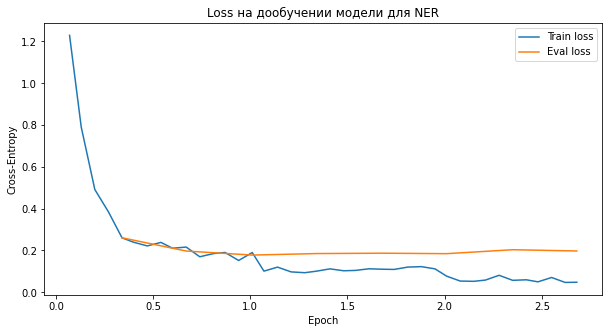

In [4]:
plt.figure(figsize=(10, 5))
plt.title('Loss на дообучении модели для NER')
plt.plot(train_loss.keys(), train_loss.values(), label='Train loss')
plt.plot(eval_loss.keys(), eval_loss.values(), label='Eval loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.savefig('loss_ner.pdf')

Измерим точность (accuracy) полученной NER сети на валидационной выборке.

In [13]:
from transformers import BertForTokenClassification, BertTokenizerFast, TokenClassificationPipeline
import torch
from pathlib import Path
model = BertForTokenClassification.from_pretrained('model')
tokenizer = BertTokenizerFast.from_pretrained('tokenizer')
make_ner = TokenClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    ignore_labels=[]
)
def make_prediction(input_sequence_of_words):
    result = make_ner(' '.join(input_sequence_of_words))
    try:
        labels = [(x[0]['entity']) for x in result if '##' not in x[0]['word']]
    except:
        labels = [(x['entity']) for x in result if '##' not in x['word']]
    return list(zip(input_sequence_of_words, labels))

In [14]:
import re
import json
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

p = Path('.').glob('data/markup/*.json')
data = []
for filename in p:
    with open(filename, 'rt') as file:
        data += json.load(file)
        
def includes(in_start, in_end, out_start, out_end):
    if out_start <= in_start and in_end <= out_end:
        return True
    return False

def make_tags(data):
    total_result = []
    for query in data:
        if 'ner' not in query.keys() or len(query['ner']) == 3:
            continue
        words_with_pos = [(m.group(0), m.start(), m.end()) for m in re.finditer(r'\S+', query['text'])]
        ner_list = [(x['htmllabels'][0], x['startOffset'], x['endOffset']) for x in query['ner']]
        if ner_list[0][0] == 'Пропущено':
            ner_list = []
        if len(ner_list) == 2:
            ner_list[1] = (ner_list[1][0], ner_list[0][2] + ner_list[1][1], ner_list[0][2] + ner_list[1][2])
        sentence_wtags = []
        for word, w_start, w_end in words_with_pos:
            tagged = False
            for tag, t_start, t_end in ner_list:
                if includes(w_start, w_start, t_start, t_end):
                    sentence_wtags.append((word, tag))
                    tagged = True
                    break
            if not tagged:
                sentence_wtags.append((word, 'O'))
        total_result.append(sentence_wtags)
    texts = [[x[0] for x in y] for y in total_result]
    tags = [[x[1] for x in y] for y in total_result]
    return texts, tags

texts, tags = make_tags(data)
train_texts, val_texts, train_tags, val_tags = train_test_split(texts, tags, test_size=0.05, random_state=42)

Считаем точность...

In [19]:
predicted_o = {'O':0, 'Товар':0, 'Бренд':0}
predicted_i = {'O':0, 'Товар':0, 'Бренд':0}
predicted_b = {'O':0, 'Товар':0, 'Бренд':0}
confusion_matrix = {'O':predicted_o, 'Товар':predicted_i, 'Бренд':predicted_b}

In [42]:
len(val_tags)

500

In [24]:
total_num = 0
s = 0
all_pred = []
all_tag = []
for text, tag_seq in zip(val_texts, val_tags):
    prediction = make_prediction(text)
    pred_tags = []
    for i in range(len(prediction)):
        pred_tags.append(prediction[i][1])
    for pred, real in zip(pred_tags, tag_seq):
        confusion_matrix[real][pred] += 1
    all_pred += pred_tags
    all_tag += tag_seq
    z = np.array(pred_tags) == np.array(tag_seq)
    total_num += len(z)
    s += z.sum()
acc = s / total_num

In [25]:
len(all_pred)

1149

In [26]:
len(all_tag)

1149

In [28]:
all_pred = np.array(all_pred)
all_tag = np.array(all_tag)

In [31]:
correct = 0
found = 0
for pred, tag in zip(all_pred, all_tag):
    if pred != 'O':
        found += 1
        if pred == tag:
            correct += 1

In [35]:
precision = correct / found

In [36]:
correct = 0
found = 0
for pred, tag in zip(all_pred, all_tag):
    if tag != 'O':
        found += 1
        if pred == tag:
            correct += 1

In [37]:
recall = correct / found

In [41]:
2 * precision * recall / (precision + recall)

0.9120171673819744

In [21]:
confusion_matrix

{'O': {'O': 654, 'Товар': 20, 'Бренд': 7},
 'Товар': {'O': 22, 'Товар': 412, 'Бренд': 6},
 'Бренд': {'O': 9, 'Товар': 6, 'Бренд': 13}}